In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cartopy.crs as ccrs
from pyresample import geometry, grid
import pyresample
import matplotlib.pyplot as plt
import datetime
import metpy
import datetime
import xarray as xr
from pyresample import geometry, grid
import cartopy.crs as ccrs
from sklearn.metrics import mean_squared_error
import math

/sharedData2/nshakoor/.conda/envs/fires/lib/python3.7/site-packages/pyresample/bilinear/__init__.py:49: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


In [202]:
def matchShape(refimg, newimg_full, lats, lons):
    newimg = newimg_full[lats[0]:lats[1], lons[0]:lons[1]]
    x_add = 0
    y_add = 0
    nx = 0
    ny = 0
    
    while refimg.shape != newimg.shape:
        if refimg.shape[0] > newimg.shape[0]:
            x_add += 1
            nx += 1
        elif refimg.shape[0] < newimg.shape[0]:
            x_add -= 1
            nx += 1
        if refimg.shape[1] > newimg.shape[1]:
            y_add += 1
            ny += 1
        elif refimg.shape[1] < newimg.shape[1]:
            y_add -= 1
            ny += 1
        newimg = newimg_full[lats[0]:lats[1] + x_add, lons[0]:lons[1] + y_add]
        
    lats[1] += x_add
    lons[1] += y_add

    return newimg_full[lats[0]:lats[1], lons[0]:lons[1]]

def shiftPixels(refimg, newimg_full, lats, lons):
    newimg = newimg_full[lats[0]:lats[1], lons[0]:lons[1]]
    x_add = 0
    y_add = 0
    nx = 0
    ny = 0
    
    while refimg.shape != newimg.shape:
        if refimg.shape[0] > newimg.shape[0]:
            x_add += 1
            nx += 1
        elif refimg.shape[0] < newimg.shape[0]:
            x_add -= 1
            nx += 1
        if refimg.shape[1] > newimg.shape[1]:
            y_add += 1
            ny += 1
        elif refimg.shape[1] < newimg.shape[1]:
            y_add -= 1
            ny += 1
        newimg = newimg_full[lats[0]:lats[1] + x_add, lons[0]:lons[1] + y_add]

    lats[1] += x_add
    lons[1] += y_add

    nx = 5
    ny = 5
    x_shift = np.arange(-nx-1, nx+2)
    y_shift = np.arange(-ny-1, ny+2)
    scores = []
    
    for x in x_shift:
        for y in y_shift:
            testimg = newimg_full[lats[0]+x:lats[1]+x, lons[0]+y:lons[1]+y]
            scores.append([x, y, np.corrcoef(refimg.flatten(), testimg.flatten())[0, 1]])
          
    max_score = 0
    min_score_index = 0
    
    for score_index in range(len(scores)-1):
        score = scores[score_index][-1]
        if abs(score) > abs(max_score):
            max_score = score
            max_score_index = score_index
            
    min_x, min_y, max_score = scores[max_score_index]
    print(min_x, min_y)
    return newimg_full[lats[0]+min_x:lats[1]+min_x, lons[0]+min_y:lons[1]+min_y]

In [188]:
landsat_path = '../landsat_files/landsat_files/'
goes_path = '../landsat_files/'
goes_red = np.load(goes_path + 'OR_ABI-L1b-RadC-M6C02_G17_s20212401846176_e20212401848549_c20212401848572.npy')

In [189]:
pc = ccrs.PlateCarree()
pc_params = pc.proj4_params
pc_extents = [-124.25, 32.25, -114.25, 42.25]
shape = [500, 500]
target_area = geometry.AreaDefinition.from_extent('CA', pc_params, shape, pc_extents)

latlon1A = [40.49, -121.45]
latlon2A = [40.650000000000006, -121.17]
coords1A = target_area.get_array_coordinates_from_lonlat(latlon1A[1], latlon1A[0])
coords1A = (round(coords1A[0]), round(coords1A[1]))
coords2A = target_area.get_array_coordinates_from_lonlat(latlon2A[1], latlon2A[0])
coords2A = (round(coords2A[0]), round(coords2A[1]))
lonsA = [coords1A[0], coords2A[0]]
latsA = [coords2A[1], coords1A[1]]

latlon1B = [39.91, -120.97]
latlon2B = [40.13, -120.49000000000001]
coords1B = target_area.get_array_coordinates_from_lonlat(latlon1B[1], latlon1B[0])
coords1B = (round(coords1B[0]), round(coords1B[1]))
coords2B = target_area.get_array_coordinates_from_lonlat(latlon2B[1], latlon2B[0])
coords2B = (round(coords2B[0]), round(coords2B[1]))
lonsB = [coords1B[0], coords2B[0]]
latsB = [coords2B[1], coords1B[1]]

-2 0
-2 0


Text(0.5, 1.0, 'GOES Image Original B')

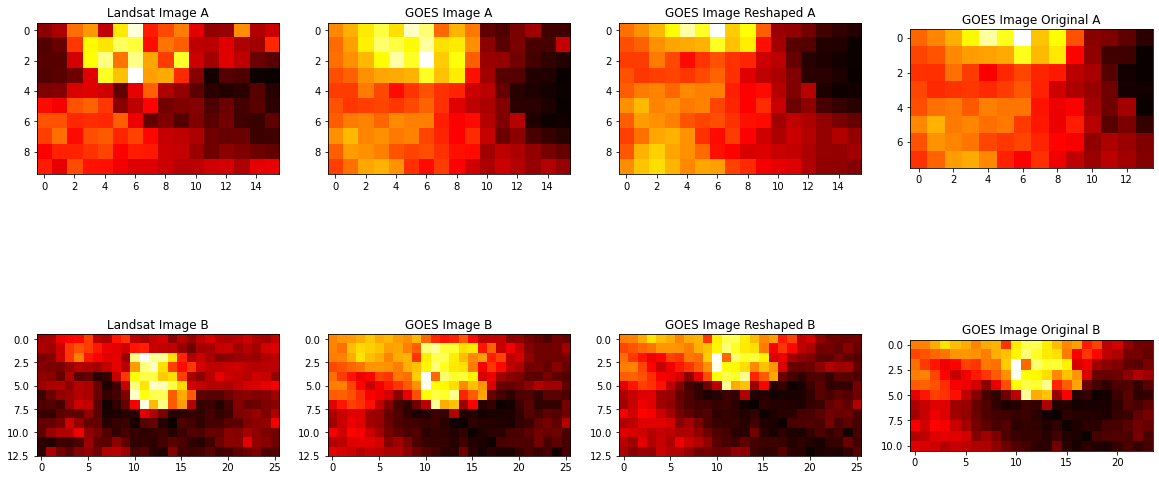

In [216]:
landsat_img_red_A = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_red_gridAcent0.02deg.npy'))
goes_img_red_A = shiftPixels(landsat_img_red_A, goes_red, [latsA[0], latsA[1]], [lonsA[0], lonsA[1]])
goes_img_reshaped_red_A = matchShape(landsat_img_red_A, goes_red, [latsA[0], latsA[1]], [lonsA[0], lonsA[1]])
goes_img_original_red_A = goes_red[latsA[0]:latsA[1], lonsA[0]:lonsA[1]]

landsat_img_red_B = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_red_gridBcent0.02deg.npy'))
goes_img_red_B = shiftPixels(landsat_img_red_B, goes_red, [latsB[0], latsB[1]], [lonsB[0], lonsB[1]])
goes_img_reshaped_red_B = matchShape(landsat_img_red_B, goes_red, [latsB[0], latsB[1]], [lonsB[0], lonsB[1]])
goes_img_original_red_B = goes_red[latsB[0]:latsB[1], lonsB[0]:lonsB[1]]

f, (ax1, ax2) = plt.subplots(2, 4, figsize=(20, 10))
ax1[0].imshow(landsat_img_red_A, vmin = landsat_img_red_A.min(), vmax = landsat_img_red_A.max(), cmap='hot')
ax1[0].set_title('Landsat Image A')
ax1[1].imshow(goes_img_red_A, vmin = goes_img_red_A.min(), vmax = goes_img_red_A.max(), cmap='hot')
ax1[1].set_title('GOES Image A')
ax1[2].imshow(goes_img_reshaped_red_A, vmin = goes_img_reshaped_red_A.min(), vmax = goes_img_reshaped_red_A.max(), cmap='hot')
ax1[2].set_title('GOES Image Reshaped A')
ax1[3].imshow(goes_img_original_red_A, vmin = goes_img_original_red_A.min(), vmax = goes_img_original_red_A.max(), cmap='hot')
ax1[3].set_title('GOES Image Original A')

ax2[0].imshow(landsat_img_red_B, vmin = landsat_img_red_B.min(), vmax = landsat_img_red_B.max(), cmap='hot')
ax2[0].set_title('Landsat Image B')
ax2[1].imshow(goes_img_red_B, vmin = goes_img_red_B.min(), vmax = goes_img_red_B.max(), cmap='hot')
ax2[1].set_title('GOES Image B')
ax2[2].imshow(goes_img_reshaped_red_B, vmin = goes_img_reshaped_red_B.min(), vmax = goes_img_reshaped_red_B.max(), cmap='hot')
ax2[2].set_title('GOES Image Reshaped B')
ax2[3].imshow(goes_img_original_red_B, vmin = goes_img_original_red_B.min(), vmax = goes_img_original_red_B.max(), cmap='hot')
ax2[3].set_title('GOES Image Original B')

Text(0, 0.5, 'Landsat Values')

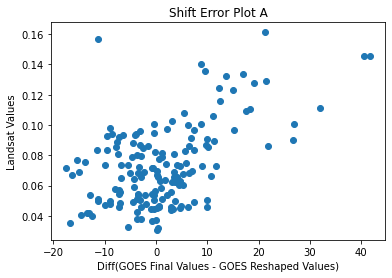

In [209]:
plt.scatter(goes_img_red_A-goes_img_reshaped_red_A, landsat_img_red_A)
plt.title('Shift Error Plot A')
plt.xlabel('Diff(GOES Final Values - GOES Reshaped Values)')
plt.ylabel('Landsat Values')

Text(0, 0.5, 'Landsat Values')

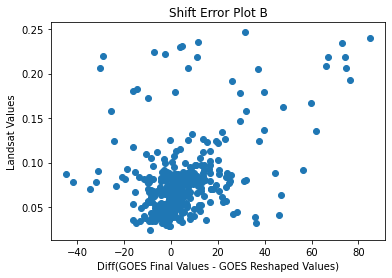

In [212]:
plt.scatter(goes_img_red_B-goes_img_reshaped_red_B, landsat_img_red_B)
plt.title('Shift Error Plot B')
plt.xlabel('Diff(GOES Final Values - GOES Reshaped Values)')
plt.ylabel('Landsat Values')